In [65]:
import os

# Function to load data from folder structure
def load_data_from_folder(root_folder):
    data = {'text': [], 'label': []}
    labels = os.listdir(root_folder)

    for label in labels:
        label_path = os.path.join(root_folder, label)
        if os.path.isdir(label_path):
            files = os.listdir(label_path)
            for file in files:
                file_path = os.path.join(label_path, file)
                if "item" not in file_path.split("/")[-1]: continue
                if os.path.isfile(file_path):
                    with open(file_path, 'r', encoding='utf-8') as f:
                        text = f.read()
                        data['text'].append(text)
                        data['label'].append(label.split(" ")[0])

    return data

# Load data from your folder structure
root_folder = '../data/guideline-data'
dataset = load_data_from_folder(root_folder)

In [66]:
# Convert to DataFrame
import pandas as pd
df = pd.DataFrame(dataset)

# Split into training and testing sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['text'], df['label'], test_size=0.2, random_state=42)

In [67]:
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

# Create a pipeline with a CountVectorizer and Multinomial Naive Bayes classifier
model = Pipeline([
     ('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', BernoulliNB()),
 ])

In [68]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': [1e-2, 1e-3, 1e-4]
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Print the best parameters and the corresponding accuracy
print("Best parameters found:")
print(grid_search.best_params_)
print(f"Best accuracy: {grid_search.best_score_:.2f}")

# Use the best model for predictions
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

Best parameters found:
{'clf__alpha': 0.01, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}
Best accuracy: 0.70


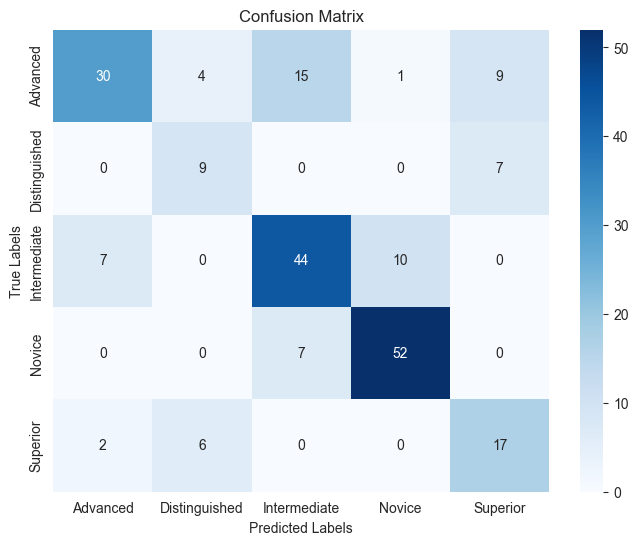

In [69]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [70]:
import joblib

joblib.dump(best_model, '../trained_models/proficiency-classifier.joblib')

['../trained_models/proficiency-classifier.joblib']